# Load Data

In [242]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import soundscapy as sspy
from scipy import stats
import rpyskewnorm as snpy
import scipydists as dists
from soundscapy.utils.parameters import PAQ_IDS, LANGUAGE_ANGLES
import circumplex as cx

from utils import spi
import utils

warnings.filterwarnings("ignore")


In [243]:
# Load latest ISD dataset
# data = sspy.isd.load_zenodo()
# Load latest ISD dataset
isd_file = Path("ISD v1.0 Data.csv")

data = pd.read_csv(isd_file)
data, excl_data = sspy.isd.validate(data)
data = data.query("Language != 'cmn'")

# Exclude RegentsParkJapan outliers
# excl_id = list(data.query("LocationID == 'RegentsParkJapan'").query("ISOEventful > 0.72 | ISOEventful < -0.5").index)
# Excluded RegentsParkFields outliers
# excl_id = excl_id + list(data.query("LocationID == 'RegentsParkFields' and ISOPleasant < 0").index) # Helicopters
excl_id = [652, 706, 548, 550, 551, 553, 569, 580, 609, 618, 623, 636, 643]
data.drop(excl_id, inplace=True)

data

Renaming PAQ columns.
Checking PAQ data quality.
Identified 109 samples to remove.
[6, 9, 13, 30, 32, 46, 190, 213, 229, 244, 296, 412, 413, 428, 464, 485, 655, 734, 739, 762, 766, 780, 1067, 1274, 1290, 1316, 1320, 1338, 1346, 1347, 1397, 1425, 1431, 1446, 1447, 1470, 1485, 1491, 1504, 1505, 1510, 1512, 1517, 1522, 1523, 1527, 1599, 1698, 1734, 1817, 1911, 1948, 2069, 2107, 2109, 2111, 2150, 2199, 2277, 2293, 2384, 2386, 2490, 2523, 2584, 2592, 2695, 2762, 2767, 2783, 2789, 2825, 2826, 2832, 2840, 2856, 2859, 2879, 2883, 2889, 2910, 2932, 2956, 2969, 3031, 3058, 3077, 3124, 3149, 3163, 3185, 3202, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3272, 3302, 3365, 3414, 3491, 3502, 3510, 3517, 3533, 3583]

1638 rows × 142 columns

## Calculate ISO Coordinates

### Standard ISO Projection

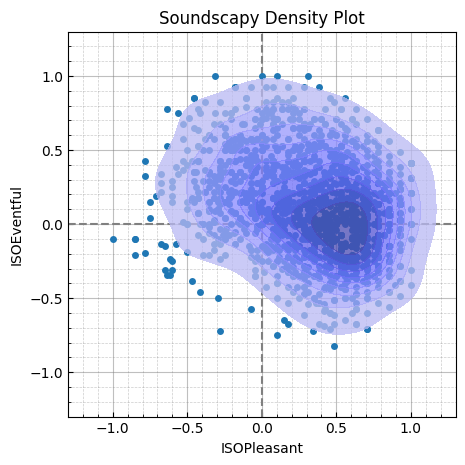

In [304]:
iso_data = data.copy()
iso_data = sspy.surveys.add_iso_coords(iso_data)
sspy.plotting.density(iso_data, xlim=(-1.3, 1.3), ylim=(-1.3, 1.3))

### SATP ISO Projection

Using corrected angles

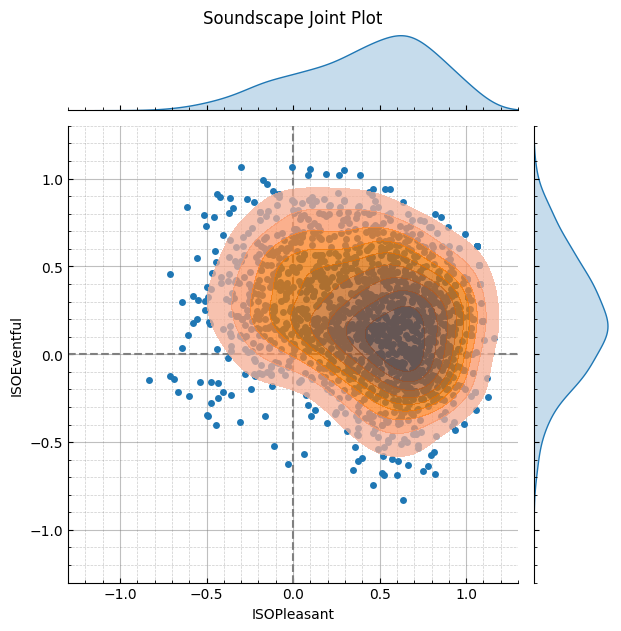

In [306]:
satp_data = data.copy()

for i, row in satp_data.iterrows():
    lang = row['Language']
    angles = LANGUAGE_ANGLES[lang]
    iso_pl, iso_ev = sspy.surveys.adj_iso_pl(row[PAQ_IDS], angles, scale=4), sspy.surveys.adj_iso_ev(row[PAQ_IDS], angles, scale=4)
    satp_data.loc[i, 'ISOPleasant'] = iso_pl
    satp_data.loc[i, 'ISOEventful'] = iso_ev
    
sspy.plotting.jointplot(satp_data, xlim=(-1.3, 1.3), ylim=(-1.3, 1.3))


### SSM Method

In [302]:
def ssm_coords(items: np.array, angles: tuple) -> tuple:
    ssm_params = cx.ssm_parameters(items, angles)
    return ssm_params[1:3]

scale = 0.4

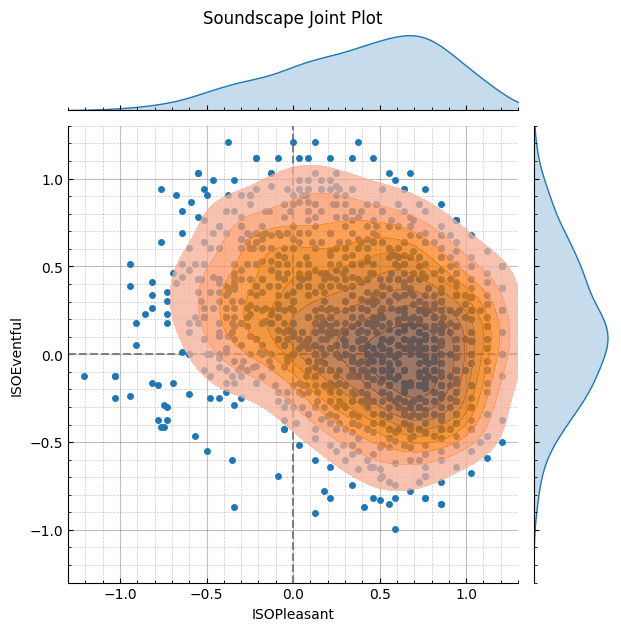

In [303]:
ssm_data = data.copy()
for i, row in ssm_data.iterrows():
    coords = ssm_coords((row[PAQ_IDS] - 3) / 2, angles=cx.OCTANTS)
    ssm_data.loc[i, ['ISOPleasant', 'ISOEventful']] = coords

sspy.plotting.jointplot(ssm_data, xlim=(-1.3, 1.3), ylim=(-1.3, 1.3))

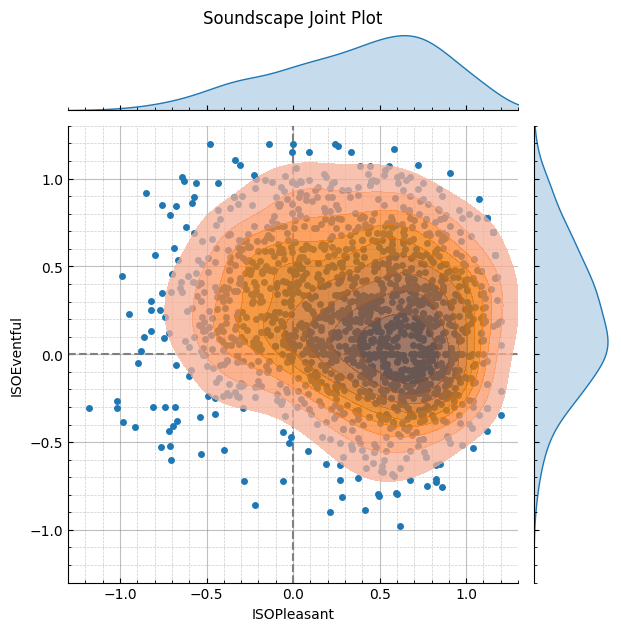

In [308]:
ssm_satp_data = data.copy()

for i, row in ssm_data.iterrows():
    lang = row['Language']
    angles = LANGUAGE_ANGLES[lang]
    coords = ssm_coords((row[PAQ_IDS] - 3) / 2, angles)
    ssm_satp_data.loc[i, ['ISOPleasant', 'ISOEventful']] = coords
# coords = data.apply(lambda x: ssm_coords(x[PAQ_IDS] * scale, LANGUAGE_ANGLES['eng']), axis=1)
# ssm_data[['ISOPleasant', 'ISOPleasant']] = coords

sspy.plotting.jointplot(ssm_satp_data, xlim=(-1.3, 1.3), ylim=(-1.3, 1.3))

## Testing the distribution methods

In [309]:
def try_benchmark(data):
    res = {}
    for location in data.LocationID.unique():
        loc_data = sspy.isd.select_location_ids(data, location)[['ISOPleasant', 'ISOEventful']]
        res[location] = utils.ks2d2s(loc_data, loc_data, extra=True)
    res = pd.DataFrame.from_dict(res, orient='index', columns=["p", "D"])
    return res

def try_msn(data):
    res = {}
    for location in data.LocationID.unique():
        # split out location data
        loc_data = sspy.isd.select_location_ids(data, location)[['ISOPleasant', 'ISOEventful']]
        # fit selm model to get parameters
        try:
            loc_m = snpy.selm("ISOPleasant", "ISOEventful", data=loc_data)
        except:
            print("Error in selm fit for: ", location)
            continue
        try:
            loc_Y = snpy.sample_msn(loc_m, n=1000)
        except:
            print("Error in sample_msn for: ", location)
            continue
           
        loc_Y = pd.DataFrame(loc_Y, columns=['ISOPleasant', 'ISOEventful'])
        res[location] = utils.ks2d2s(loc_data, loc_Y, extra=True)
    res = pd.DataFrame.from_dict(res, orient='index', columns=["p", "D"])
    return res

def try_mtsn(data):
    res = {}
    for location in data.LocationID.unique():
        # split out location data
        loc_data = sspy.isd.select_location_ids(data, location)[['ISOPleasant', 'ISOEventful']]
        # fit selm model to get parameters
        try:
            loc_m = snpy.selm("ISOPleasant", "ISOEventful", data=loc_data)
        except:
            print("Error in selm fit for: ", location)
            continue
        try:
            loc_Y = snpy.sample_mtsn(loc_m, n=1000)
        except:
            print("Error in sample_mtsn for: ", location)
            continue
            
        loc_Y = pd.DataFrame(loc_Y, columns=['ISOPleasant', 'ISOEventful'])
        res[location] = utils.ks2d2s(loc_data, loc_Y, extra=True)
    res = pd.DataFrame.from_dict(res, orient='index', columns=["p", "D"])
    return res


def try_scipy_tsn(data):
    res = {}
    for location in data.LocationID.unique():
        # split out location data
        loc_data = sspy.isd.select_location_ids(data, location)[['ISOPleasant', 'ISOEventful']]
        # fit selm model to get parameters
        loc, scale, alpha = dists.estimate_skew_moments_2d(loc_data[['ISOPleasant', 'ISOEventful']].to_numpy())
        loc_Y = dists.scipy_tsn_2d(loc, scale, alpha, num_samples=1000)            
        loc_Y = pd.DataFrame(loc_Y, columns=['ISOPleasant', 'ISOEventful'])
        res[location] = utils.ks2d2s(loc_data, loc_Y, extra=True)
    res = pd.DataFrame.from_dict(res, orient='index', columns=["p", "D"])
    return res


def try_scipy_msn(data):
    res = {}
    for location in data.LocationID.unique():
        # split out location data
        loc_data = sspy.isd.select_location_ids(data, location)[['ISOPleasant', 'ISOEventful']]
        mean, cov, skew = dists.estimate_msn_moments(
            loc_data[['ISOPleasant', 'ISOEventful']].to_numpy()
            )
        loc_Y = dists.scipy_msn(shape=skew, cov=cov, mean=mean).rvs_slow(1000)
        loc_Y = pd.DataFrame(loc_Y, columns=['ISOPleasant', 'ISOEventful'])
        res[location] = utils.ks2d2s(loc_data, loc_Y, extra=True)
    res = pd.DataFrame.from_dict(res, orient='index', columns=["p", "D"])
    return res


def try_scipy_mn(data):
    res = {}
    for location in data.LocationID.unique():
        # split out location data
        loc_data = sspy.isd.select_location_ids(data, location)[['ISOPleasant', 'ISOEventful']]
        mean, cov, _ = dists.estimate_msn_moments(
            loc_data[['ISOPleasant', 'ISOEventful']].to_numpy()
            )
        loc_Y = dists.scipy_mn(mean, cov, num_samples=1000)
        loc_Y = pd.DataFrame(loc_Y, columns=['ISOPleasant', 'ISOEventful'])
        res[location] = utils.ks2d2s(loc_data, loc_Y, extra=True)
    res = pd.DataFrame.from_dict(res, orient='index', columns=["p", "D"])
    return res

def try_scipy_mtn(data):
    res = {}
    for location in data.LocationID.unique():
        # split out location data
        loc_data = sspy.isd.select_location_ids(data, location)[['ISOPleasant', 'ISOEventful']]
        mean, cov, _ = dists.estimate_msn_moments(
            loc_data[['ISOPleasant', 'ISOEventful']].to_numpy()
            )
        loc_Y = dists.scipy_mtn(mean, cov, num_samples=1000)
        loc_Y = pd.DataFrame(loc_Y, columns=['ISOPleasant', 'ISOEventful'])
        res[location] = utils.ks2d2s(loc_data, loc_Y, extra=True)
    res = pd.DataFrame.from_dict(res, orient='index', columns=["p", "D"])
    return res


def try_scipy_tn(data):
    res = {}
    for location in data.LocationID.unique():
        # split out location data
        loc_data = sspy.isd.select_location_ids(data, location)[['ISOPleasant', 'ISOEventful']]
        mean = loc_data[['ISOPleasant', 'ISOEventful']].mean().to_numpy()
        stddev = loc_data[['ISOPleasant', 'ISOEventful']].std().to_numpy()
        loc_Y = dists.scipy_tn_2d(mean, stddev, num_samples=1000)
        loc_Y = pd.DataFrame(loc_Y, columns=['ISOPleasant', 'ISOEventful'])
        res[location] = utils.ks2d2s(loc_data, loc_Y, extra=True)
    res = pd.DataFrame.from_dict(res, orient='index', columns=["p", "D"])
    return res
    


In [310]:
print("Running benchmarks for ISO")
iso_res = {}
iso_res['benchmark'] = try_benchmark(iso_data)
iso_res['msn'] = try_msn(iso_data)
iso_res['mtsn'] = try_mtsn(iso_data)
iso_res['scipy_mn'] = try_scipy_mn(iso_data)
iso_res['scipy_tn'] = try_scipy_tn(iso_data)
iso_res['scipy_mtn'] = try_scipy_mtn(iso_data)
iso_res['scipy_tsn'] = try_scipy_tsn(iso_data)
iso_res['scipy_msn'] = try_scipy_msn(iso_data)

print("Running benchmarks for SATP")
satp_res = {}
satp_res['benchmark'] = try_benchmark(satp_data)
satp_res['msn'] = try_msn(satp_data)
satp_res['mtsn'] = try_mtsn(satp_data)
satp_res['scipy_mn'] = try_scipy_mn(satp_data)
satp_res['scipy_tn'] = try_scipy_tn(satp_data)
satp_res['scipy_mtn'] = try_scipy_mtn(satp_data)
satp_res['scipy_tsn'] = try_scipy_tsn(satp_data)
satp_res['scipy_msn'] = try_scipy_msn(satp_data)

print("Running benchmarks for SSM")
ssm_res = {}
ssm_res['benchmark'] = try_benchmark(ssm_data)
ssm_res['msn'] = try_msn(ssm_data)
ssm_res['mtsn'] = try_mtsn(ssm_data)
ssm_res['scipy_mn'] = try_scipy_mn(ssm_data)
ssm_res['scipy_tn'] = try_scipy_tn(ssm_data)
ssm_res['scipy_mtn'] = try_scipy_mtn(ssm_data)
ssm_res['scipy_tsn'] = try_scipy_tsn(ssm_data)
ssm_res['scipy_msn'] = try_scipy_msn(ssm_data)

print("Running benchmarks for SSM_SATP")
ssm_satp_res = {}
ssm_satp_res['benchmark'] = try_benchmark(ssm_satp_data)
ssm_satp_res['msn'] = try_msn(ssm_satp_data)
ssm_satp_res['mtsn'] = try_mtsn(ssm_satp_data)
ssm_satp_res['scipy_mn'] = try_scipy_mn(ssm_satp_data)  
ssm_satp_res['scipy_tn'] = try_scipy_tn(ssm_satp_data)
ssm_satp_res['scipy_mtn'] = try_scipy_mtn(ssm_satp_data)
ssm_satp_res['scipy_tsn'] = try_scipy_tsn(ssm_satp_data)
ssm_satp_res['scipy_msn'] = try_scipy_msn(ssm_satp_data)

iso_res = pd.concat(iso_res, axis=1)
satp_res = pd.concat(satp_res, axis=1)
ssm_res = pd.concat(ssm_res, axis=1)
ssm_satp_res = pd.concat(ssm_satp_res, axis=1)



Running benchmarks for ISO
Error in sample_msn for:  RegentsParkJapan
Error in sample_mtsn for:  RegentsParkJapan
Running benchmarks for SATP
Running benchmarks for SSM
Running benchmarks for SSM_SATP

R[write to console]: Error in chol.default(lot$aux$Psi) : 
  the leading minor of order 2 is not positive

R[write to console]: Error in chol.default(lot$aux$Psi) : 
  the leading minor of order 2 is not positive


In [311]:
res = pd.DataFrame({
    "iso": iso_res.mean(),
    "satp": satp_res.mean(),
    "ssm": ssm_res.mean(),
    "ssm_satp": ssm_satp_res.mean()
})
res

In [301]:
ssm_satp_res

------------------------------------------------------------------------

## Usage Examples

In [87]:
test_data = sspy.isd.select_location_ids(data, 'RegentsParkJapan')


In [88]:
import rpyskewnorm as snpy

m = snpy.selm(
    x = "ISOPleasant",
    y = "ISOEventful",
    data = test_data,
    )

cp = snpy.extract_cp(m)
dp = snpy.extract_dp(m)
print(f"mean: {cp[0]}")
print(f"cov: {cp[1]}")
print(f"skew: {cp[2]}")

print("\n")
print(f"xi: {dp[0]}")
print(f"omega: {dp[1]}")
print(f"alpha: {dp[2]}")

mean: [[0.76569249 0.1337267 ]]
cov: [[0.05304569 0.01325881]
 [0.01325881 0.06333638]]
skew: [-0.99252395 -0.00648337]


xi: [[1.07026046 0.19593844]]
omega: [[0.14580734 0.03220651]
 [0.03220651 0.06720668]]
alpha: [-31277540.37912534    848852.67981869]

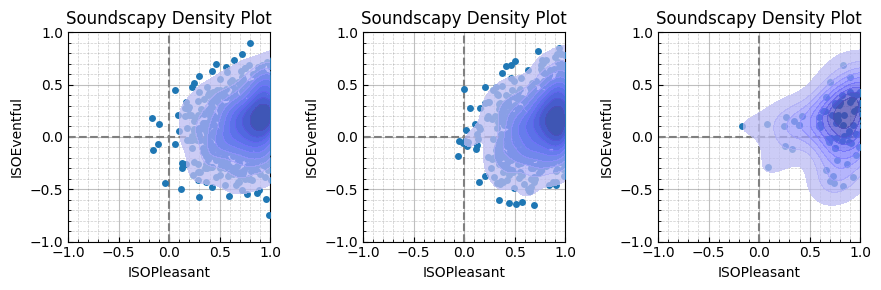

In [89]:
Y1 = snpy.sample_msn(xi = dp[0], omega=dp[1], alpha=dp[2], n=1000)
Y1 = pd.DataFrame(Y1, columns=['ISOPleasant', 'ISOEventful'])

Y2 = snpy.sample_msn(m, n=1000)
Y2 = pd.DataFrame(Y2, columns=['ISOPleasant', 'ISOEventful'])

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
sspy.plotting.density(Y1, ax=axes[0])
sspy.plotting.density(Y2, ax=axes[1])
sspy.plotting.density(test_data, ax=axes[2])
plt.tight_layout()

print(spi(test_data[['ISOPleasant', 'ISOEventful']], Y1))
print(spi(test_data[['ISOPleasant', 'ISOEventful']], Y2))
print(spi(Y1, Y2))



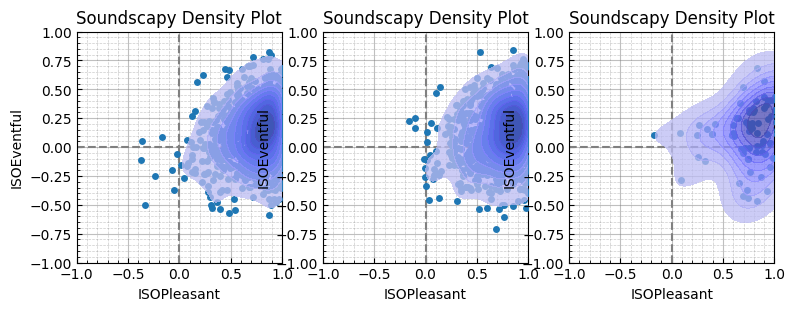

In [90]:
Yt1 = snpy.sample_mtsn(m, n=1000)
Yt1 = pd.DataFrame(Yt1, columns=['ISOPleasant', 'ISOEventful'])

Yt2 = snpy.sample_mtsn(xi = dp[0], omega=dp[1], alpha=dp[2], n=1000)
Yt2 = pd.DataFrame(Yt2, columns=['ISOPleasant', 'ISOEventful'])

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
sspy.plotting.density(Yt1, ax=axes[0])
sspy.plotting.density(Yt2, ax=axes[1])
sspy.plotting.density(test_data, ax=axes[2])

print(spi(test_data[['ISOPleasant', 'ISOEventful']], Yt1))
print(spi(test_data[['ISOPleasant', 'ISOEventful']], Yt2))
print(spi(Yt1, Yt2))


options explored:

Multivariate Truncated Normal:

-   trun_mvnt:
    https://github.com/ralphma1203/trun_mvnt?tab=readme-ov-file
-   StackOverflow:
    https://stackoverflow.com/questions/20115917/truncated-multivariate-normal-in-scipy

Univariate Skew Normal: -
http://azzalini.stat.unipd.it/SN/Intro/intro.html

# Truncated Skew-Normal

In [566]:
# draw a sample
def truncated_skew_normal(loc: float, scale: float, skew: float, a: float = -1, b: float = 1, num_samples: int = 1000):
    # Parameters for the skew-normal distribution
    # delta = skew / np.sqrt(1 + skew**2)
    # delta = skew
    # Rejection sampling
    samples = []
    while len(samples) < num_samples:
        candidate = stats.skewnorm.rvs(a=skew, loc=loc, scale=scale)
        if a <= candidate <= b:
            samples.append(candidate)
    return np.array(samples)


def estimate_skew_moments(samples: np.array):
    skew, loc, scale = stats.skewnorm.fit(samples)
    return loc, scale, skew


def trunc_skewnorm_2d(loc: tuple, scale: tuple, skew: tuple, a: tuple = (-1, -1), b: tuple = (1, 1), num_samples=1000):
    samples = np.array(
            [
                truncated_skew_normal(loc[0], scale[0], skew[0], a[0], b[0], num_samples),
                truncated_skew_normal(loc[1], scale[1], skew[1], a[1], b[1], num_samples)
                ]
            ).T
    return samples


def estimate_skew_moments_2d(samples: np.array):
    loc_0, scale_0, skew_0 = estimate_skew_moments(samples[:, 0])
    loc_1, scale_1, skew_1 = estimate_skew_moments(samples[:, 1])
    return (loc_0, loc_1), (scale_0, scale_1), (skew_0, skew_1)


Note that the location, scale, and skew/shape parameters (referred to as
‘direct parameters’ by Azzalini) are distinct from the mean, covariance,
and skewness parameters (referred to as ‘centred parameters’).
http://azzalini.stat.unipd.it/SN/Intro/intro.html

(0.8186226102942695, 0.6859803261389701, -4.20548006334138)

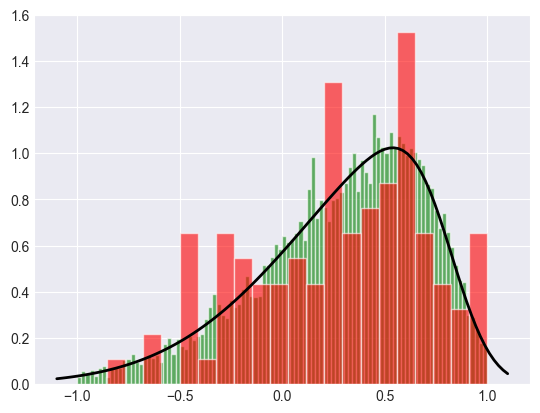

In [567]:
0# loc_s, scale_s, skew_s = (0.377, 0.0827, -0.083)
# print((loc_s, scale_s, skew_s))
# s_data = truncated_skew_normal(loc_s, scale_s, skew_s, num_samples=10000)
s_data = test_data['ISOPleasant'].to_numpy()
loc_p, scale_p, skew_p = estimate_skew_moments(s_data)
p_data = truncated_skew_normal(loc_p, scale_p, skew_p, num_samples=10000)
print((loc_p, scale_p, skew_p))

# plot the pdfs
plt.figure()
plt.hist(p_data, bins=100, density=True, alpha=0.6, color='g')
plt.hist(s_data, bins=21, density=True, alpha=0.6, color='r')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.skewnorm.pdf(x, skew_p, loc_p, scale_p)
plt.plot(x, p, 'k', linewidth=2)

In [568]:
targets = estimate_skew_moments_2d(test_data[['ISOPleasant', 'ISOEventful']].to_numpy())
print(targets)
p_data = trunc_skewnorm_2d(targets[0], targets[1], targets[2], num_samples=10000)
sample_moments = estimate_skew_moments_2d(p_data)
print(sample_moments)

((0.8186226102942695, -0.33616237140375016), (0.6859803261389701, 0.39567973474924745), (-4.20548006334138, 3.116395598533704))
((0.8128313333487476, -0.33028171176693866), (0.6663039964642805, 0.3877676207947591), (-5.155976610981078, 2.9096536098316017))

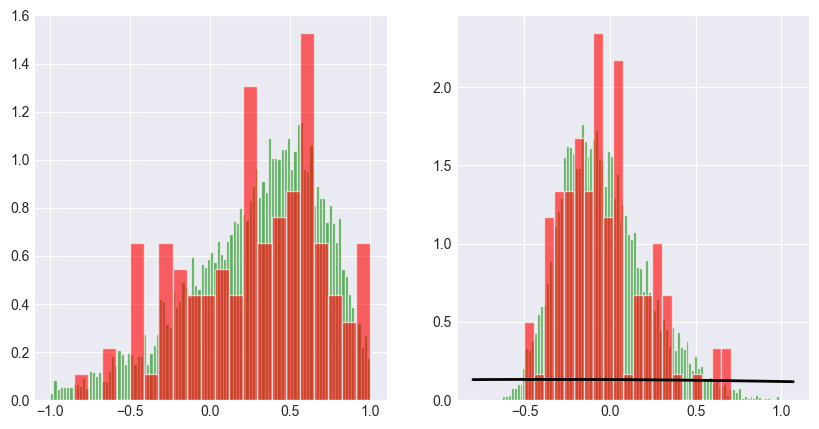

In [569]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].hist(p_data[:, 0], bins=100, density=True, alpha=0.6, color='g')
axes[0].hist(test_data['ISOPleasant'], bins=21, density=True, alpha=0.6, color='r')
xmin, xmax = axes[0].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.skewnorm.pdf(x, targets[0][0], targets[1][0], targets[2][0])
axes[0].plot(x, p, 'k', linewidth=2)

axes[1].hist(p_data[:, 1], bins=100, density=True, alpha=0.6, color='g')
axes[1].hist(test_data['ISOEventful'], bins=21, density=True, alpha=0.6, color='r')
xmin, xmax = axes[1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.skewnorm.pdf(x, targets[0][1], targets[1][1], targets[2][1])
axes[1].plot(x, p, 'k', linewidth=2)

plt.show()

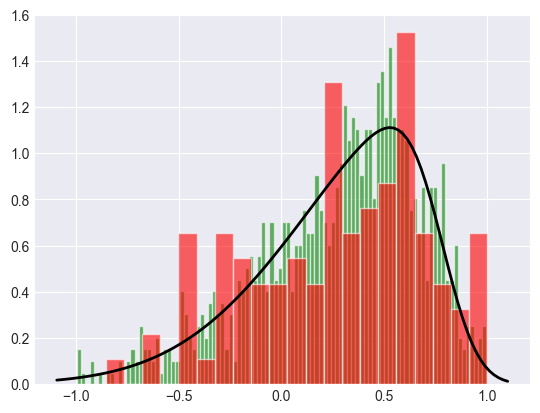

In [570]:
a, loc, scale = stats.skewnorm.fit(test_data['ISOPleasant'])

p_data = truncated_skew_normal(loc, scale, a, -1, 1, num_samples=1000)

# estimate parameters from sample
ae, loce, scalee = stats.skewnorm.fit(p_data)

# plot the pdfs
plt.figure()
plt.hist(p_data, bins=100, density=True, alpha=0.6, color='g')
plt.hist(test_data['ISOPleasant'], bins=21, density=True, alpha=0.6, color='r')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.skewnorm.pdf(x, ae, loce, scalee)
plt.plot(x, p, 'k', linewidth=2)

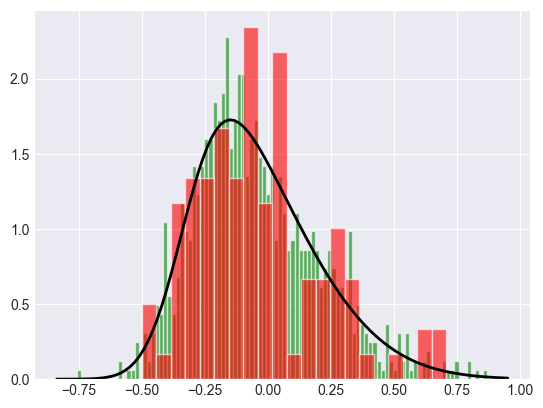

In [571]:
a, loc, scale = stats.skewnorm.fit(test_data['ISOEventful'])

e_data = truncated_skew_normal(loc, scale, a, -1, 1, num_samples=1000)

# estimate parameters from sample
ae, loce, scalee = stats.skewnorm.fit(e_data)

# plot the pdfs
plt.figure()
plt.hist(e_data, bins=100, density=True, alpha=0.6, color='g')
plt.hist(test_data['ISOEventful'], bins=21, density=True, alpha=0.6, color='r')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.skewnorm.pdf(x, ae, loce, scalee)
plt.plot(x, p, 'k', linewidth=2)

In [572]:
from utils import spi

target_data = pd.DataFrame(
        {
            'ISOPleasant': p_data,
            'ISOEventful': e_data
            }
        )

spi(test_data[['ISOPleasant', 'ISOEventful']], target_data)

86

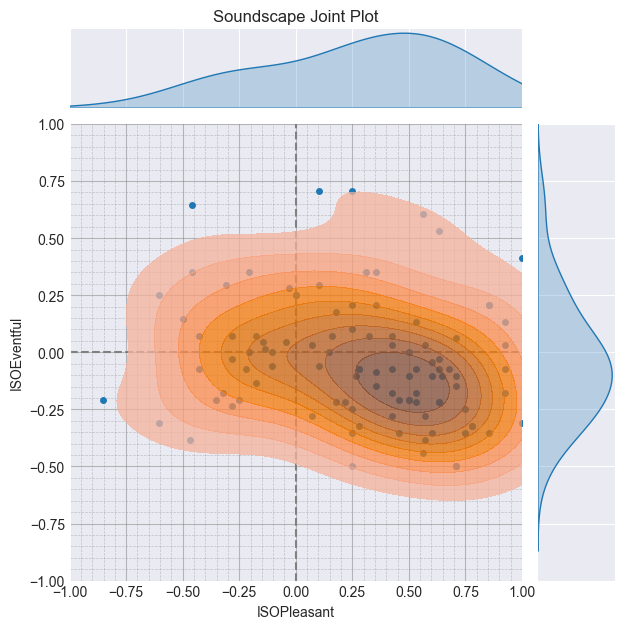

In [573]:
sspy.plotting.jointplot(test_data)

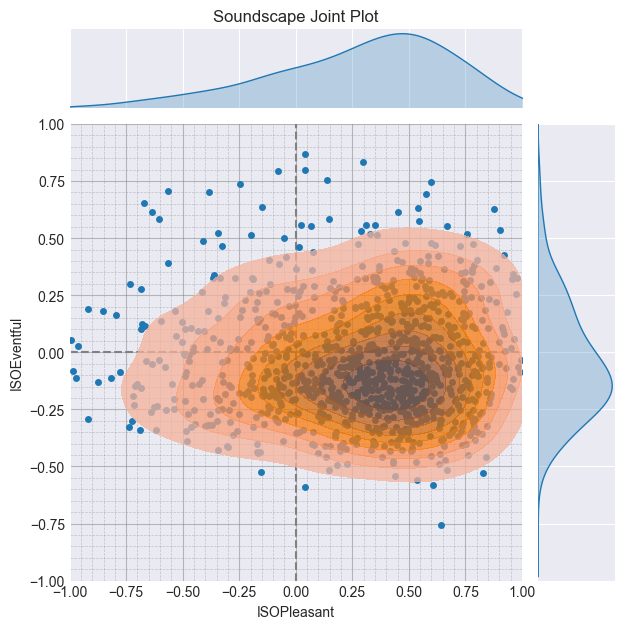

In [574]:
sspy.plotting.jointplot(target_data)

In [575]:
spi(sspy.isd.select_location_ids(data, 'SanMarco'), target_data)


43

# Multivariate Skew-Normal

In [576]:


import numpy as np
from scipy.stats import (multivariate_normal as mvn,
                         norm
                         )
from scipy.stats._multivariate import _squeeze_output


class multivariate_skewnorm:
    # from: https://gregorygundersen.com/blog/2020/12/29/multivariate-skew-normal/
    def __init__(self, shape, mean=(0, 0), cov=None):
        self.dim = len(shape)
        self.shape = np.asarray(shape)
        self.mean = np.asarray(mean)
        self.cov = np.eye(self.dim) if cov is None else np.asarray(cov)

    def pdf(self, x):
        return np.exp(self.logpdf(x))

    def logpdf(self, x):
        x = mvn._process_quantiles(x, self.dim)
        pdf = mvn(self.mean, self.cov).logpdf(x)
        cdf = norm(0, 1).logcdf(np.dot(x, self.shape))
        return _squeeze_output(np.log(2) + pdf + cdf)

    def rvs_slow(self, size=1):
        # K-variate normal density
        std_mvn = mvn(self.mean,
                      self.cov
                      )
        x = np.empty((size, self.dim))

        # Apply rejection sampling.
        n_samples = 0
        while n_samples < size:
            z = std_mvn.rvs(size=1)
            u = np.random.uniform(0, 2 * std_mvn.pdf(z))
            if not u > self.pdf(z):
                x[n_samples] = z
                n_samples += 1

        # Rescale based on correlation matrix.
        # chol = np.linalg.cholesky(self.cov)
        # x = (chol @ x.T).T

        return x

    def rvs_fast(self, size=1):
        aCa = self.shape @ self.cov @ self.shape
        delta = (1 / np.sqrt(1 + aCa)) * self.cov @ self.shape
        cov_star = np.block([[np.ones(1), delta],
                             [delta[:, None], self.cov]]
                            )
        x = mvn(np.zeros(self.dim + 1), cov_star).rvs(size)
        x0, x1 = x[:, 0], x[:, 1:]
        inds = x0 <= 0
        x1[inds] = -1 * x1[inds]
        return x1


def estimate_moments(samples):
    # Calculate sample mean
    sample_mean = np.mean(samples, axis=0)

    # Calculate sample covariance matrix
    sample_cov_matrix = np.cov(samples, rowvar=False)

    # Center the samples
    centered_samples = samples - sample_mean

    # Calculate skewness matrix using the centered samples
    skewness_matrix = np.mean(centered_samples ** 3, axis=0) / np.std(centered_samples, axis=0) ** 3

    return sample_mean, sample_cov_matrix, skewness_matrix


Estimated Mean: [ 0.27909904 -0.03652308]
Estimated Covariance Matrix:
[[ 0.18122578 -0.02137291]
 [-0.02137291  0.06742474]]
Estimated Skewness: [-0.45149117  0.73468857]

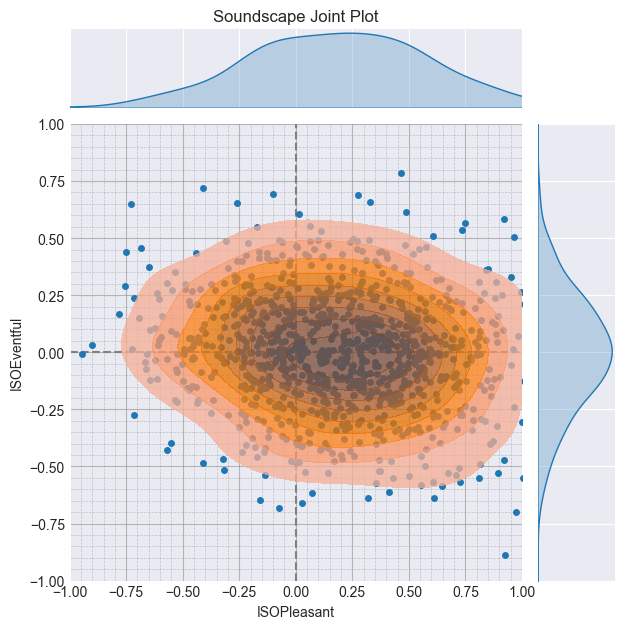

In [577]:
estimated_mean, estimated_cov_matrix, estimated_skewness = estimate_moments(
    test_data[['ISOPleasant', 'ISOEventful']].to_numpy()
    )

print("Estimated Mean:", estimated_mean)
print("Estimated Covariance Matrix:")
print(estimated_cov_matrix)
print("Estimated Skewness:", estimated_skewness)

targets = {
    'mean': (0.224, 0.377),
    'cov' : np.array([[0.099, -0.018], [-0.0183, 0.0827]]),
    'skew': (0.089, -0.083)
    }

test_df = multivariate_skewnorm(shape=estimated_skewness, cov=estimated_cov_matrix, mean=estimated_mean).rvs_slow(1000)
# test_df = multivariate_skewnorm(shape=targets['skew'], cov=targets['cov'], mean=targets['mean']).rvs_slow(1000)

test_df = pd.DataFrame(test_df, columns=['ISOPleasant', 'ISOEventful'])

sspy.plotting.jointplot(test_df)

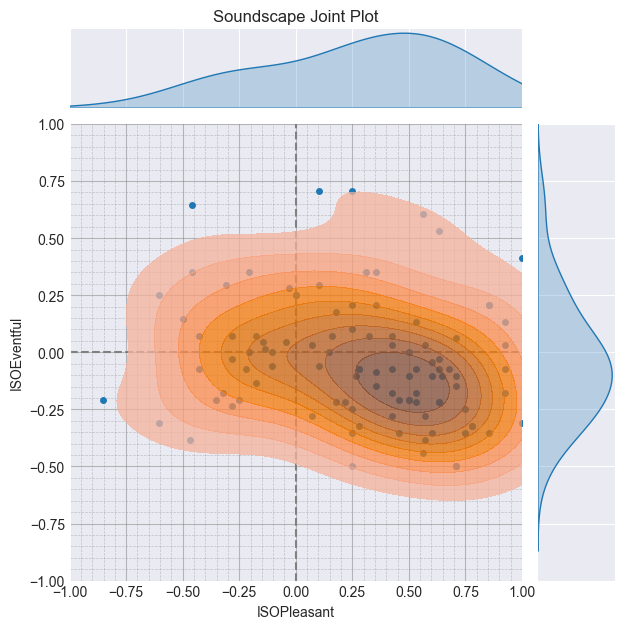

In [578]:
sspy.plotting.jointplot(test_data)

In [579]:
spi(sspy.isd.select_location_ids(data, 'SanMarco'), test_df)

46

## R SN

In [5]:
import rpyskewnorm as snpy

sigma = np.array([[1, 0.4], [0.4, 0.6]])
mean = (0, -1)
skew = (0, -0.6)
beta, omega, alpha = snpy.skewnormal_parms_2d(mean, sigma, skew)
print(beta, omega, alpha)
y = snpy.rnd_skewnormal_2d(beta, omega, alpha, size=20)

[ 0.         -0.13389297] [[1.         0.4       ]
 [0.4        1.35014139]] [  3.66054584 -10.63348162]

-0.03652307692307693 0.2596627369069606 0.745484116696089
-0.3486524345620716 0.4060165918261776 3.598957128011734

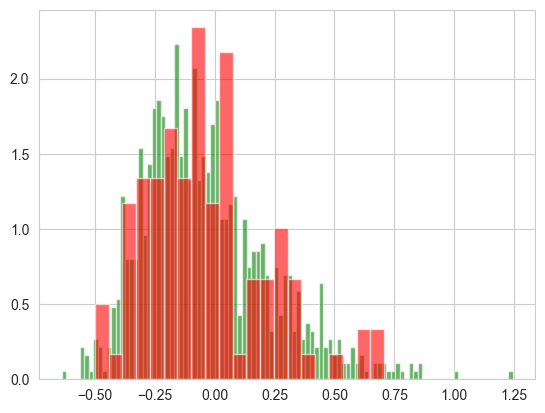

In [6]:
mean = test_data['ISOEventful'].mean()
std = test_data['ISOEventful'].std()
skew = test_data['ISOEventful'].skew()
print(mean, std, skew)

beta, omega, alpha = snpy.skewnormal_parms(mean, std, skew)
print(beta, omega, alpha)
y = snpy.rnd_skewnormal(beta, omega, alpha, size=1000)

# plot the pdfs
plt.figure()
plt.hist(y, bins=100, density=True, alpha=0.6, color='g')
plt.hist(test_data['ISOEventful'], bins=21, density=True, alpha=0.6, color='r')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
plt.show()

## End

In [203]:
import numpy as np


def multivariate_skew_normal(mean, cov_matrix, skewness, size=1):
    dim = len(mean)

    # Generate samples from the multivariate normal distribution
    normal_samples = multivariate_normal.rvs(mean=mean, cov=cov_matrix, size=size)

    # Generate samples from the skewness distribution
    skew_samples = skewnorm.rvs(skewness, size=(size, dim))

    # Combine the normal samples and skew samples
    skewed_samples = normal_samples + skew_samples

    return skewed_samples


# Example usage:
mean_vector = np.array([1, 0])
covariance_matrix = np.array([[1, 0.9], [0.9, 1]])
skewness_parameter = 2

samples = multivariate_skew_normal(mean_vector, covariance_matrix, skewness_parameter, size=1000)

print("Sample Mean:", np.mean(samples, axis=0))
print("Sample Covariance Matrix:")
print(np.cov(samples, rowvar=False))


Sample Mean: [1.70380847 0.66459427]
Sample Covariance Matrix:
[[1.55894132 0.93562762]
 [0.93562762 1.54235095]]

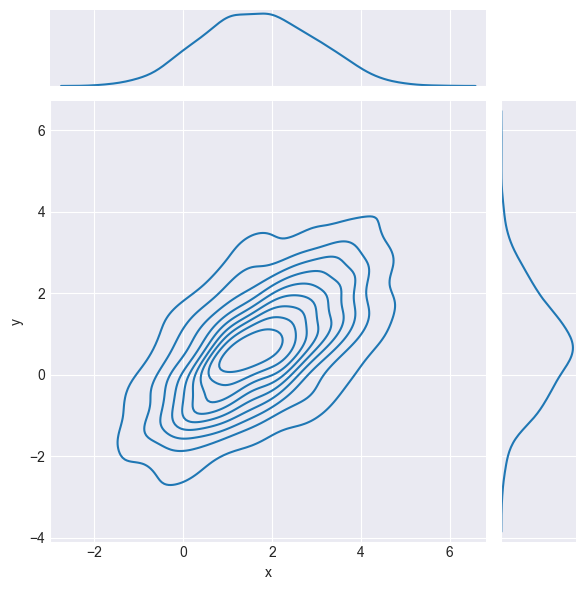

In [204]:
test_df = pd.DataFrame(samples, columns=['x', 'y'])
sns.jointplot(data=test_df, x='x', y='y', kind='kde')

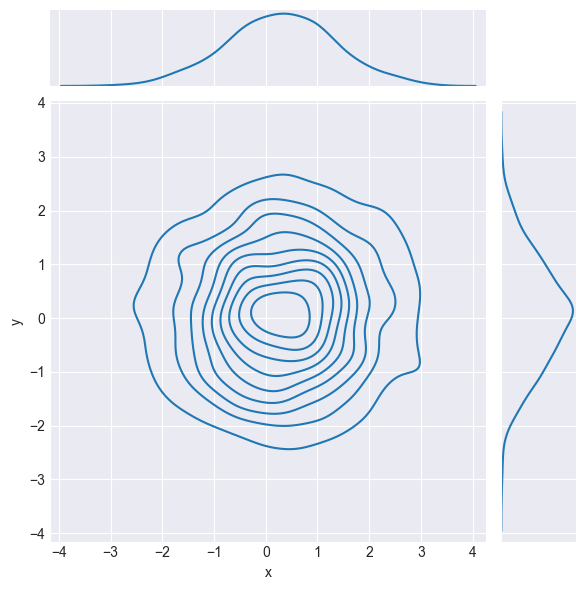

In [209]:
samples = multivariate_skew_normal(
        mean=test_data[['ISOPleasant', 'ISOEventful']].mean().to_numpy(),
        cov_matrix=test_data[['ISOPleasant', 'ISOEventful']].cov().to_numpy(),
        skewness=0,
        size=1000
        )

samples = pd.DataFrame(samples, columns=['x', 'y'])
sns.jointplot(data=samples, x='x', y='y', kind='kde')

In [213]:
import numpy as np
from scipy.stats import multivariate_normal, skewnorm
from scipy.optimize import minimize


def fit_multivariate_skew_normal(samples):
    dim = samples.shape[1]

    # Function to minimize (negative log-likelihood)
    def negative_log_likelihood(params):
        mean = params[:dim]
        cov_matrix = np.diag(np.exp(params[dim:2 * dim]))
        skewness = params[2 * dim:]

        # Calculate log-likelihood
        normal_density = multivariate_normal.logpdf(samples, mean=mean, cov=cov_matrix)
        skew_density = skewnorm.logpdf((samples - mean) / np.sqrt(np.diag(cov_matrix)), skewness)

        return -np.sum(normal_density + skew_density)

    # Initial guess for parameters
    initial_params = np.concatenate(
            [samples.mean(axis=0), np.log(np.diag(np.cov(samples, rowvar=False))), np.zeros(dim)]
            )

    # Optimize the negative log-likelihood
    result = minimize(negative_log_likelihood, initial_params, method='L-BFGS-B')

    # Extract parameters from the optimized result
    fitted_mean = result.x[:dim]
    fitted_cov_matrix = np.diag(np.exp(result.x[dim:2 * dim]))
    fitted_skewness = result.x[2 * dim:]

    return fitted_mean, fitted_cov_matrix, fitted_skewness


# Example usage:
# Assume 'data' is a 2D array of samples
data = np.random.multivariate_normal(mean=[2, 3], cov=[[1, 0.5], [0.5, 2]], size=1000)
fit_mean, fit_cov_matrix, fit_skewness = fit_multivariate_skew_normal(data)

print("Fitted Mean:", fit_mean)
print("Fitted Covariance Matrix:")
print(fit_cov_matrix)
print("Fitted Skewness:", fit_skewness)



In [233]:
sample = multivariate_normal.rvs([2, 3], [[1, 0.5], [0.5, 2]]) + skewnorm.rvs([2, -1])
sample[0] < 1 and sample[1] < 1 and sample[0] > -1 and sample[1] > -1

True

In [298]:
import numpy as np
from scipy.stats import multivariate_normal, skewnorm


def sample_bivariate_skew_normal(size, location, covariance, skewness, a=-1, b=1):
    # Rejection sampling
    samples = []
    while len(samples) < size:
        candidate = multivariate_normal.rvs(mean=location, cov=covariance) * skewnorm.rvs(skewness)
        if a <= candidate[0] <= b and a <= candidate[1] <= b:
            samples.append(candidate)

    return samples


# Example usage:
size = 1000
location = [0.5, -0.5]
covariance = [[1, 0.5], [0.5, 2]]
skewness = [2, -1]

samples = sample_bivariate_skew_normal(size, location, covariance, skewness)

# Print mean and covariance matrix of the generated samples
print("Sample Mean:", np.mean(samples, axis=0))
print("Sample Covariance Matrix:")
print(np.cov(samples, rowvar=False))


Sample Mean: [0.09059921 0.0597697 ]
Sample Covariance Matrix:
[[ 0.1769003  -0.00457141]
 [-0.00457141  0.20086224]]

In [299]:
import numpy as np


def estimate_moments(samples):
    # Calculate sample mean
    sample_mean = np.mean(samples, axis=0)

    # Calculate sample covariance matrix
    sample_cov_matrix = np.cov(samples, rowvar=False)

    # Center the samples
    centered_samples = samples - sample_mean

    # Calculate skewness matrix using the centered samples
    skewness_matrix = np.mean(centered_samples ** 3, axis=0) / np.std(centered_samples, axis=0) ** 3

    return sample_mean, sample_cov_matrix, skewness_matrix


# Example usage:
# Assume 'data' is a 2D array of samples
data = np.random.multivariate_normal(mean=[0.5, -0.5], cov=[[1, 0.5], [0.5, 2]], size=1000)

# Estimate moments
estimated_mean, estimated_cov_matrix, estimated_skewness = estimate_moments(data)

print("Estimated Mean:", estimated_mean)
print("Estimated Covariance Matrix:")
print(estimated_cov_matrix)
print("Estimated Skewness:", estimated_skewness)


Estimated Mean: [ 0.43266242 -0.56365521]
Estimated Covariance Matrix:
[[1.01840587 0.47906665]
 [0.47906665 1.90171325]]
Estimated Skewness: [0.04232562 0.19124746]

In [300]:
estimated_mean, estimated_cov_matrix, estimated_skewness = estimate_moments(
    test_data[['ISOPleasant', 'ISOEventful']].to_numpy()
    )

print("Estimated Mean:", estimated_mean)
print("Estimated Covariance Matrix:")
print(estimated_cov_matrix)
print("Estimated Skewness:", estimated_skewness)


Estimated Mean: [0.25715484 0.07943226]
Estimated Covariance Matrix:
[[ 0.15379664 -0.02063052]
 [-0.02063052  0.08202177]]
Estimated Skewness: [-0.36778486 -0.40921456]

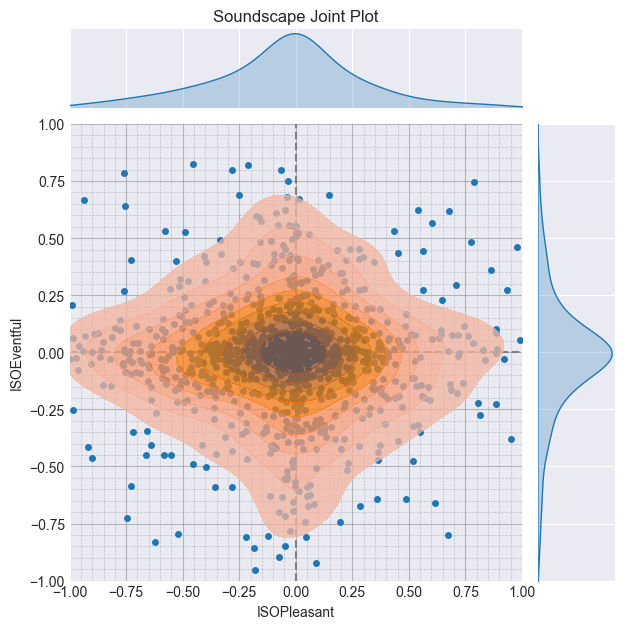

In [301]:
data = sample_bivariate_skew_normal(location=estimated_mean, covariance=estimated_cov_matrix,
                                    skewness=estimated_skewness, size=1000
                                    )

data = pd.DataFrame(data, columns=['ISOPleasant', 'ISOEventful'])

sspy.plotting.jointplot(data)

In [302]:
data

1000 rows × 2 columns

------------------------------------------------------------------------

jupyter: kernelspec: display_name: Python 3 language: python name:
python3 language_info: codemirror_mode: name: ipython version: 3
file_extension: .py mimetype: text/x-python name: python
nbconvert_exporter: python pygments_lexer: ipython3 version: 3.11.4

------------------------------------------------------------------------